<a href="https://colab.research.google.com/github/KORALLLL/summer_practice/blob/main/bagging/2net4bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Second FC NN for bagging

##Configuration

датасет: MNIST[6000:12000]

размер обучающей выборки: 6000(сырого) + 14000(аугментаций)

размер тестирующей выборки: 10000

количество скрытых слоёв: 3

количество нейронов в скрытых слоя: 200

функция активации: сигмоида

функция потерь: кросс энтропия

оптимизатор: RMSprop

скорость обучение: 0.001

размер батча: 1000

количество эпох: 700


##Prepairing data

In [1]:
start = 6000
stop = 12000

import torch
import torchvision.datasets
import torchvision.transforms
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as bar
from PIL import Image
from copy import deepcopy

def augmentation(old_image, label):
  old_image = Image.fromarray(old_image.numpy(), mode='L')

  rotater = torchvision.transforms.RandomRotation(degrees = (-15, 15))
  h_flipper = torchvision.transforms.RandomHorizontalFlip(p=1) #only for 08
  v_flipper = torchvision.transforms.RandomVerticalFlip(p=1) #only for 08
  shifter = torchvision.transforms.RandomAffine(0, translate = (2/28,2/28))
  compressor = torchvision.transforms.RandomAffine(0, scale = (0.8, 0.9))
  stratcher = torchvision.transforms.RandomAffine(0, scale = (1.05, 1.1))

  seed1 = random.randint(0, 3)
  if label == 0 or label == 8:
    if seed1 == 0:
      image = old_image
    elif seed1 == 1:
      image = h_flipper(old_image)
    elif seed1 == 2:
      image = v_flipper(old_image)
    else:
      image = h_flipper(v_flipper(old_image))
  else:
    image = old_image

  seed = random.randint(0,10)
  if seed == 0: #rot
    new_image = rotater(image)
  elif seed == 1: #shift
    new_image = shifter(image)
  elif seed == 2: #comp
    new_image = compressor(image)
  elif seed == 3: #str
    new_image = stratcher(image)
  elif seed == 4: #rot+shift
    new_image = rotater(shifter(image))
  elif seed == 5: #rot+comp
    new_image = rotater(compressor(image))
  elif seed == 6: #rot+str
    new_image = rotater(stratcher(image))
  elif seed == 7: #shift+comp
    new_image = shifter(compressor(image))
  elif seed == 8: #shift+stretch
    new_image = shifter(stratcher(image))
  elif seed == 9: #rot+shift+comp
    new_image = rotater(shifter(compressor(image)))
  elif seed == 10: #tor+shift+stretch
    new_image = rotater(shifter(stratcher(image)))

  new_image = torchvision.transforms.ToTensor()(new_image)
  new_image = new_image.squeeze()
  return(new_image)


mnist_train = torchvision.datasets.MNIST('./', download = True, train = True)
mnist_test = torchvision.datasets.MNIST('./', download = True, train = False)

train_data = mnist_train.data[start:stop]
train_labels = mnist_train.targets[start:stop]

temp_train_data, temp_train_label = [], []
random_indexes = random.choices(range(0,6000), k=14000)

for i in random_indexes:
  image, label = train_data[i], train_labels[i]
  new_image = augmentation(image, label)
  temp_train_data.append(new_image)
  temp_train_label.append(label)

temp_train_data = torch.stack(temp_train_data)
temp_train_label = torch.stack(temp_train_label)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_data = torch.cat([train_data, temp_train_data], dim = 0).float().reshape([-1,28*28]).to(device)
train_labels = torch.cat([train_labels, temp_train_label], dim = 0).to(device)
test_data = mnist_test.data.float().reshape([-1, 28*28]).to(device)
test_labels = mnist_test.targets.to(device)

100%|██████████| 9912422/9912422 [00:00<00:00, 387118114.34it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23250613.02it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 99038971.74it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5729482.34it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Configuration net

In [2]:
class MNISTNet(torch.nn.Module):
  def __init__(self):
    super(MNISTNet, self).__init__()
    self.fc1 = torch.nn.Linear(28*28, 200)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(200, 200)
    self.act2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(200, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

## Hyperparameters

In [3]:
loss = torch.nn.CrossEntropyLoss()
batch_size = 1000

## test learning on 5000 epoch

In [10]:
train_accuracy_history = []
test_accuracy_history = []
train_loss_history = []
test_loss_history = []

net = MNISTNet().to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr = 0.001)

for epoch in bar(range(5000), desc = 'learning'):
  order = np.random.permutation(len(train_data))

  for start_index in range(0, len(train_data), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    train_data_batch = train_data[batch_indexes]
    train_labels_batch = train_labels[batch_indexes]

    pred = net.forward(train_data_batch)

    loss_val = loss(pred, train_labels_batch)
    loss_val.backward()

    optimizer.step()

  train_preds = net.forward(train_data)
  test_preds = net.forward(test_data)

  train_accuracy_history.append((train_preds.argmax(dim=1) == train_labels).float().mean().cpu().data)
  test_accuracy_history.append((test_preds.argmax(dim=1) == test_labels).float().mean().cpu().data)

  train_loss_history.append(loss(train_preds, train_labels).item())
  test_loss_history.append(loss(test_preds, test_labels).item())

<ipython-input-10-5998b3253cc5>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(5000), desc = 'learning'):


learning:   0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'accuracy history')

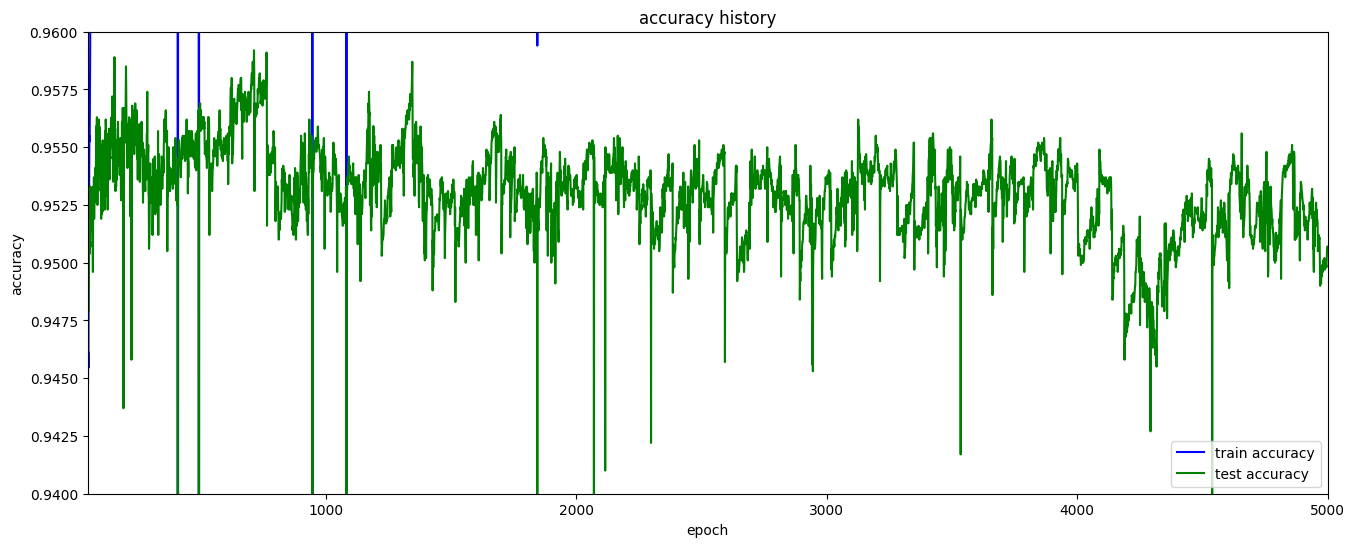

In [21]:
plt.figure(figsize = (16.0, 6.0))

plt.plot(range(5000), train_accuracy_history, c='blue', label = 'train accuracy')
plt.plot(range(5000), test_accuracy_history, c = 'green', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(50, 5000)
plt.ylim(0.94, 0.96)
plt.title('accuracy history')

Text(0.5, 1.0, 'loss history')

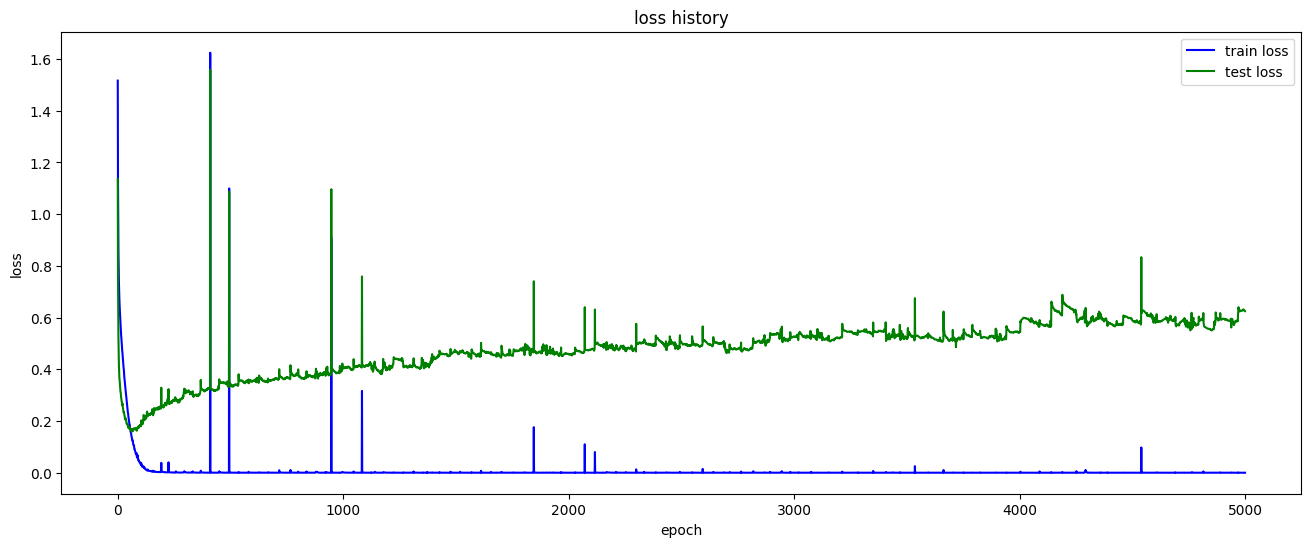

In [18]:
plt.figure(figsize = (16.0, 6.0))
plt.plot(range(5000), train_loss_history, c='blue', label = 'train loss')
plt.plot(range(5000), test_loss_history, c = 'green', label = 'test loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss history')

## learning model

In [24]:
best_accuracy = 0.0
best_state = None

for experiment in bar(range(200), desc = 'experimenting'):
  net = MNISTNet().to(device)
  optimizer = torch.optim.RMSprop(net.parameters(), lr = 0.001)

  for epoch in bar(range(700), desc = 'learning'):
    order = np.random.permutation(len(train_data))

    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]

      train_data_batch = train_data[batch_indexes]
      train_labels_batch = train_labels[batch_indexes]

      pred = net.forward(train_data_batch)

      loss_val = loss(pred, train_labels_batch)
      loss_val.backward()

      optimizer.step()

  test_preds = net.forward(test_data)

  current_accuracy = ((test_preds.argmax(dim=1) == test_labels).float().mean().cpu().data)

  if current_accuracy > best_accuracy:
    best_accuracy = current_accuracy
    best_state = deepcopy(net.state_dict())

  print(current_accuracy, best_accuracy)

<ipython-input-24-bdd999fe6a8c>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(200), desc = 'experimenting'):


experimenting:   0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-24-bdd999fe6a8c>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(700), desc = 'learning'):


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9535) tensor(0.9535)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9568) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9534) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9522) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9557) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9498) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9524) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9537) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9537) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9514) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9519) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9564) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9553) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9530) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9506) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9560) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9524) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9525) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9543) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9538) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9507) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9513) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9560) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9533) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9531) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9517) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9529) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9537) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9514) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9526) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9515) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9512) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9560) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9525) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9528) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9549) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9531) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9566) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9553) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9517) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9512) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9564) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9495) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9539) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9525) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9538) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9514) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9528) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9559) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9525) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9547) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9506) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9518) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9542) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9496) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9542) tensor(0.9568)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9576) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9533) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9525) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9539) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9539) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9515) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9526) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9520) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9524) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9542) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9513) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9517) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9526) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9493) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9547) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9519) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9574) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9516) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9543) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9528) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9518) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9559) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9533) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9537) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9542) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9501) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.8559) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9565) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9566) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9551) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9512) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9535) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9554) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9532) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9520) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9550) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9521) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9528) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9549) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9527) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9573) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9489) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9553) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9532) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9516) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9540) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9549) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9517) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9510) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9524) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9540) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9513) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9520) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9549) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9563) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9553) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9562) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9526) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9500) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9543) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9504) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9540) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9529) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9529) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9572) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9538) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9556) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9539) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9531) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9552) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9533) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9561) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9539) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9499) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9517) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9552) tensor(0.9576)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9581) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9535) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9542) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9522) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9514) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9510) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9530) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9555) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9527) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9570) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9533) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9561) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9529) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9527) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9551) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9543) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9521) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9496) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9542) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9525) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9498) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9519) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9534) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9553) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9497) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9532) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9545) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9523) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9540) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9549) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9507) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9536) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9512) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9560) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9517) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9550) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9503) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9560) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9540) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9549) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9541) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9535) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9565) tensor(0.9581)


learning:   0%|          | 0/700 [00:00<?, ?it/s]

tensor(0.9510) tensor(0.9581)


In [25]:
torch.save(best_state, 'parameters_2net4bagging.pth')
net = MNISTNet().to(device)
net.load_state_dict(torch.load('parameters_2net4bagging.pth'))
test_preds = net.forward(test_data)
print(((test_preds.argmax(dim=1) == test_labels).float().mean().cpu().data))

tensor(0.9581)
